In [1]:
# Disable some console warnings
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import math
import seaborn as sns
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Input, Activation
#from qkeras import quantized bits
#from qkeras import QDense, QActivation
from qkeras import *

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('data/oct4_MCwithQuantInputs/InputTrainSet.csv')
#df1

In [3]:
df2 = pd.read_csv('data/oct4_MCwithQuantInputs/labelsTrain.csv')
#df2

In [4]:
df3 = pd.read_csv('data/oct4_MCwithQuantInputs/InputTestSet.csv')
#df3

In [5]:
df4 = pd.read_csv('data/oct4_MCwithQuantInputs/labelsTest.csv')
#df4

In [6]:
X_train = df1.values
X_test = df3.values

y_train = df2.values
y_test = df4.values
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state = 0)

print('Trainig set shape         :', X_train.shape) 
print('Trainig set shape (labels):', y_train.shape)
print('Test set shape:           :', X_test.shape)
print('Test set shape (labels)   :', y_test.shape)


Trainig set shape         : (792776, 14)
Trainig set shape (labels): (792776, 1)
Test set shape:           : (198196, 14)
Test set shape (labels)   : (198196, 1)


In [7]:
#y_train

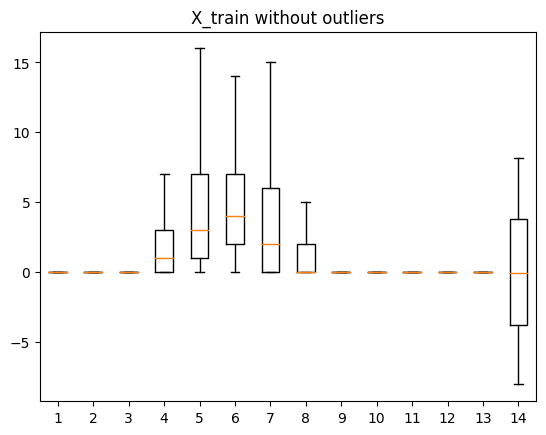

In [8]:
_ = plt.title("X_train without outliers")
_ = plt.boxplot(X_train, showfliers=False)

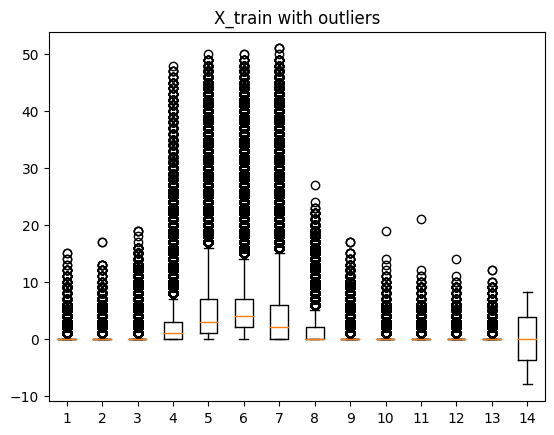

In [9]:
_ = plt.title("X_train with outliers")
_ = plt.boxplot(X_train, showfliers=True)

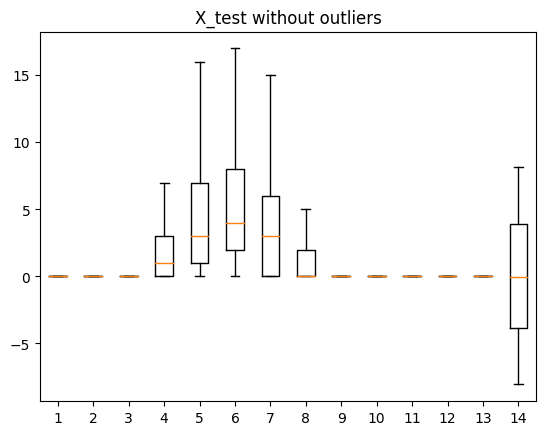

In [10]:
_ = plt.title("X_test without outliers")
_ = plt.boxplot(X_test, showfliers=False)

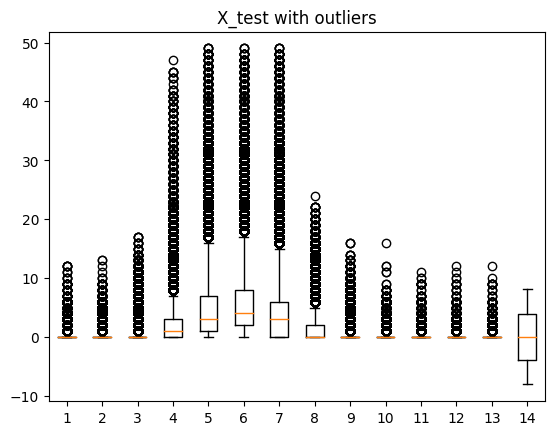

In [11]:
_ = plt.title("X_test with outliers")
_ = plt.boxplot(X_test, showfliers=True)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

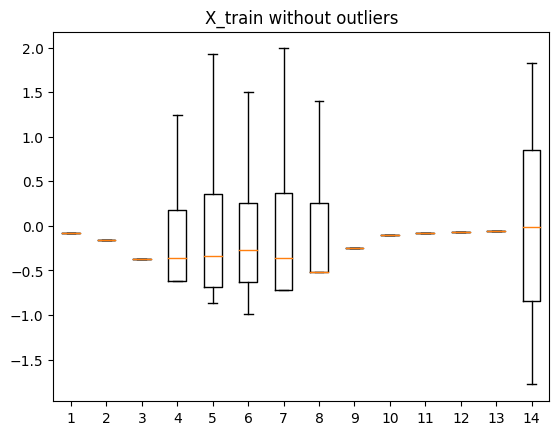

In [13]:
_ = plt.title("X_train without outliers")
_ = plt.boxplot(X_train, showfliers=False)

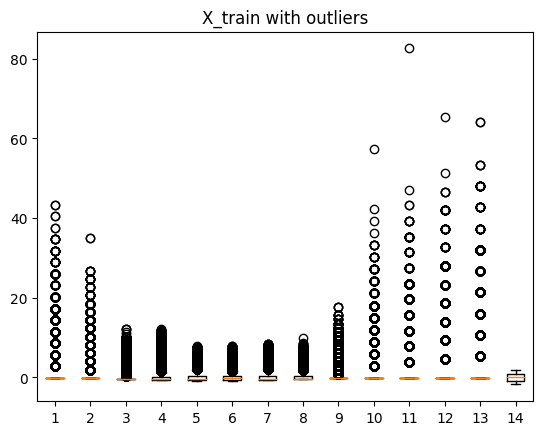

In [14]:
_ = plt.title("X_train with outliers")
_ = plt.boxplot(X_train, showfliers=True)

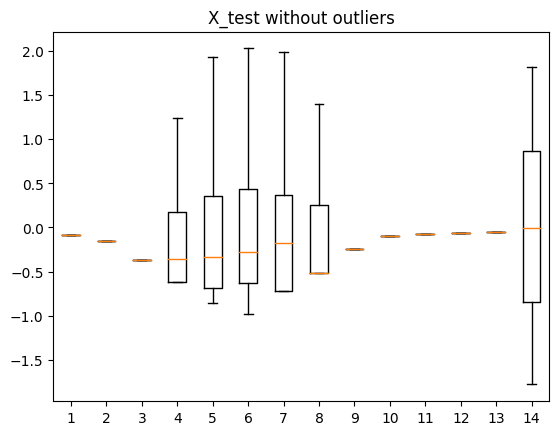

In [15]:
_ = plt.title("X_test without outliers")
_ = plt.boxplot(X_test, showfliers=False)

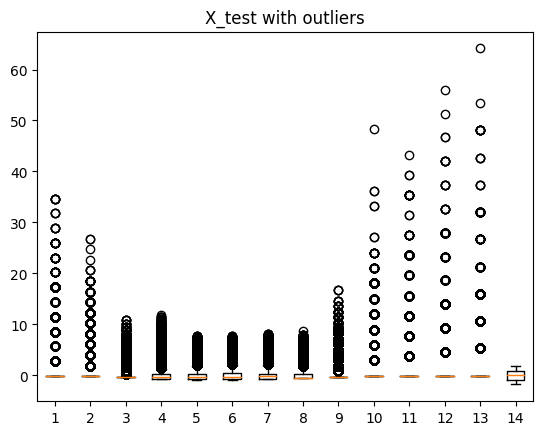

In [16]:
_ = plt.title("X_test with outliers")
_ = plt.boxplot(X_test, showfliers=True)

In [17]:
#X_test

In [18]:
def CreateQModel(shape, nb_classes):
    x = x_in = Input(shape)
    x = QDense(128,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense1")(x)
    x = keras.layers.BatchNormalization()(x)
    x = QActivation("quantized_relu(10,0)", name="relu-1")(x)
    x = QDense(3,
        kernel_quantizer=quantized_bits(5,0,alpha=1), bias_quantizer=quantized_bits(5,0,alpha=1),
        name="dense2")(x)
    x = Activation("softmax", name="softmax")(x)
    model = Model(inputs=x_in, outputs=x)
    return model
    
    

model=CreateQModel(X_train.shape[1:], y_train.shape[-1])

model.compile(optimizer=Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 14)]              0         
_________________________________________________________________
dense1 (QDense)              (None, 128)               1920      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
relu-1 (QActivation)         (None, 128)               0         
_________________________________________________________________
dense2 (QDense)              (None, 3)                 387       
_________________________________________________________________
softmax (Activation)         (None, 3)                 0         
Total params: 2,819
Trainable params: 2,563
Non-trainable params: 256
_________________________________________________________

In [19]:
model_file = 'model/qkeras_model.h5'

train_and_save = False
history = None
if train_and_save:
    es = EarlyStopping(monitor='val_sparse_categorical_accuracy', 
                                   mode='max', # don't minimize the accuracy!
                                   patience=10,
                                   restore_best_weights=True)

    history = model.fit(X_train,
                    y_train,
                    callbacks=[es],
                    epochs=150, 
                    batch_size=1024,
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0)
    
    model.save(model_file)
    
co = {}
utils._add_supported_quantized_objects(co)
model = tf.keras.models.load_model(model_file, custom_objects=co)

In [20]:
#from keras_sequential_ascii import keras2ascii
#keras2ascii(model)

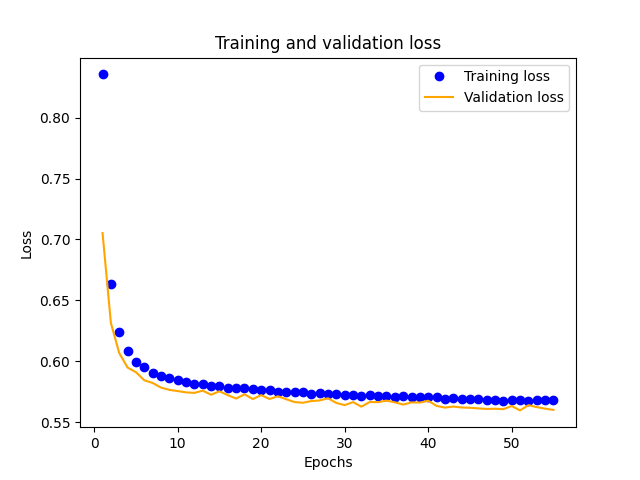

In [21]:
if train_and_save:
    history_dict = history.history
    loss_values = history_dict['loss'] 
    val_loss_values = history_dict['val_loss'] 
    epochs = range(1, len(loss_values) + 1) 
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('images/loss.png')
else:
    from PIL import Image

    img = Image.open('images/loss.png')
    display(img)

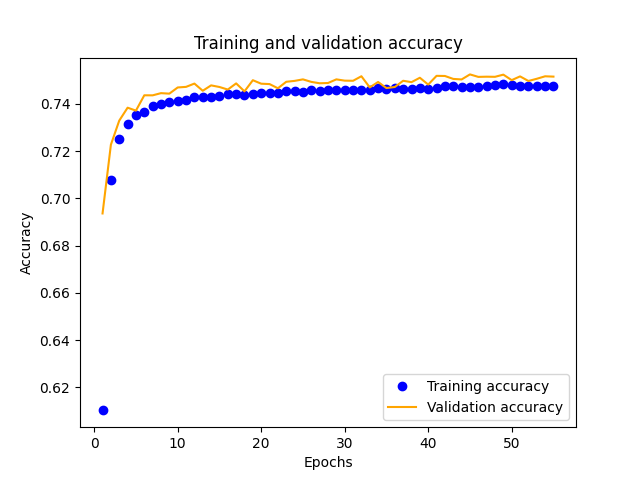

In [22]:
if train_and_save:
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    #np.max(val_acc)
    plt.savefig('images/accuracy.png')
    plt.show()
else:
    from PIL import Image
    #from os.path import exists

    img = Image.open('images/accuracy.png')
    display(img)

In [23]:
preds = model.predict(X_test) 
predictionsFiles = np.argmax(preds, axis=1)

In [24]:
#predictionsFiles

In [25]:
pd.DataFrame(predictionsFiles).to_csv("csv/predictionsFiles.csv",header='predict', index=False)

In [26]:
pd.DataFrame(y_test).to_csv("csv/true.csv",header='true', index=False)

In [27]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.5536922216415405
Test accuracy: 0.7567609548568726


Confusion matrix:
[[80273  8858  9967]
 [15121 34129   299]
 [13857   107 35585]]


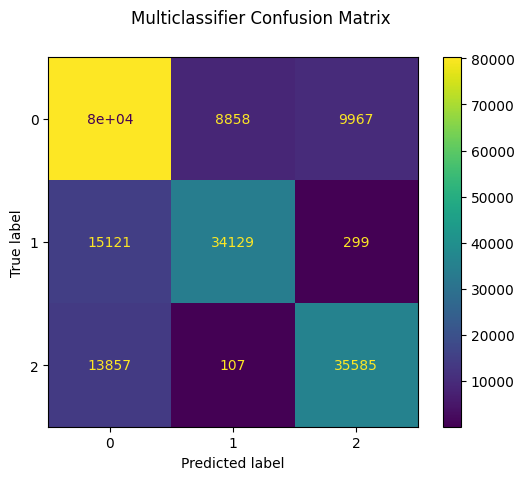

In [28]:
from sklearn import datasets, svm, metrics
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predictionsFiles)
disp.figure_.suptitle("Multiclassifier Confusion Matrix")
print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.savefig('images/confusionMatrix.png')
plt.show()

## hls4ml

In [29]:
import hls4ml
import plotting

/home/giuseppe/miniconda3/envs/cms-pix-28-env/lib/python3.8/site-packages/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")


In [30]:
print('hls4ml ver.', hls4ml.__version__)

hls4ml ver. 0.6.0


In [31]:
import os
os.environ['PATH'] = '/opt/xilinx/Vivado/2019.1/bin:' + os.environ['PATH']
def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


In [32]:
hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

hconfig = hls4ml.utils.config_from_keras_model(model, granularity='name')

hconfig['LayerName']['softmax']['exp_table_t'] = 'ap_fixed<18,8>'
hconfig['LayerName']['softmax']['inv_table_t'] = 'ap_fixed<18,4>'

for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = True

Interpreting Model
Topology:
Layer name: input_1, layer type: Input
Layer name: dense1, layer type: QDense
Layer name: batch_normalization, layer type: BatchNormalization
Layer name: relu-1, layer type: QActivation
Layer name: dense2, layer type: QDense
Layer name: softmax, layer type: Activation


In [33]:
plotting.print_dict(hconfig)

Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
LayerName
  input_1
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
  dense1
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    ReuseFactor:     1
    Trace:           True
  batch_normalization
    Precision
      scale:         ap_fixed<16,6>
      bias:          ap_fixed<16,6>
    ReuseFactor:     1
    Trace:           True
  relu-1
    Precision
      result:        ap_ufixed<10,0>
    ReuseFactor:     1
    Trace:           True
  dense2
    Precision
      weight:        ap_fixed<5,1>
      bias:          ap_fixed<5,1>
    ReuseFactor:     1
    Trace:           True
  softmax
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    exp_table_t:     ap_fixed<18,8>
    inv_table_t:     ap_fixed<18,4>
    Trace:           True


In [34]:
hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    hls_config=hconfig,
                                                    output_dir='hls4ml_prj',
                                                    part='XC7A100T')

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 14]], output shape: [None, 14]
Layer name: dense1, layer type: QDense, input shapes: [[None, 14]], output shape: [None, 128]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: relu-1, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: dense2, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model


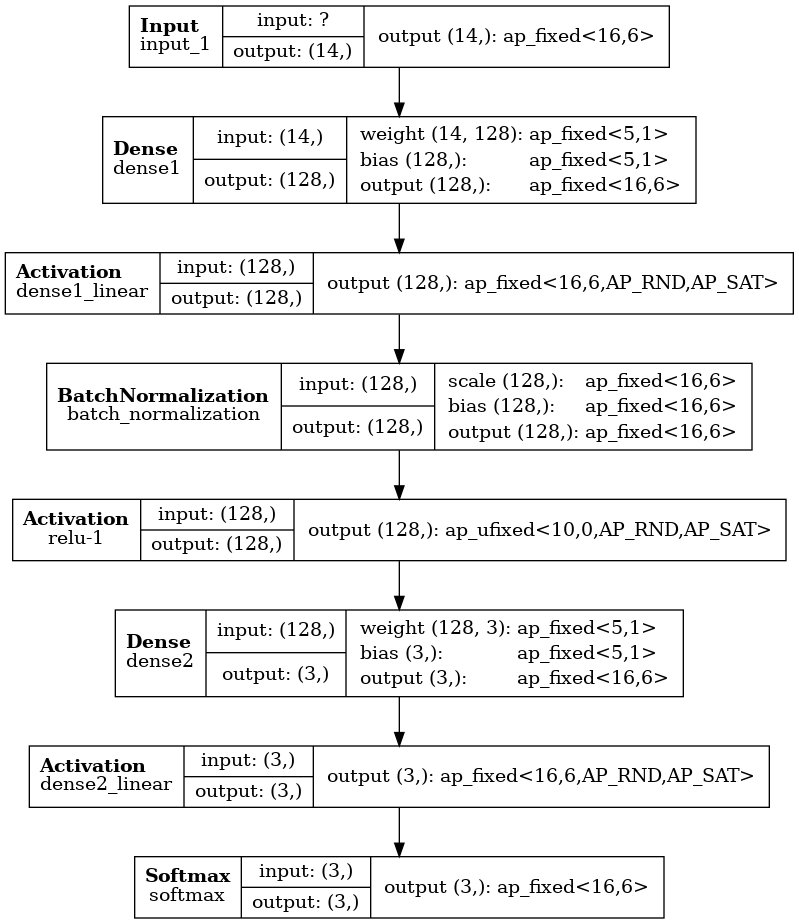

In [35]:
hls4ml.utils.plot_model(hmodel, show_shapes=True, show_precision=True, to_file=None)

In [36]:
hpreds, htrace = hmodel.trace(np.ascontiguousarray(X_test))

Recompiling myproject with tracing
Writing HLS project
Done


In [37]:
trace = hls4ml.model.profiling.get_ymodel_keras(model, X_test)

Processing input_1 in Keras model...
Processing dense1 in Keras model...
Processing batch_normalization in Keras model...
Processing relu-1 in Keras model...
Processing dense2 in Keras model...
Processing softmax in Keras model...
Done taking outputs for Keras model.


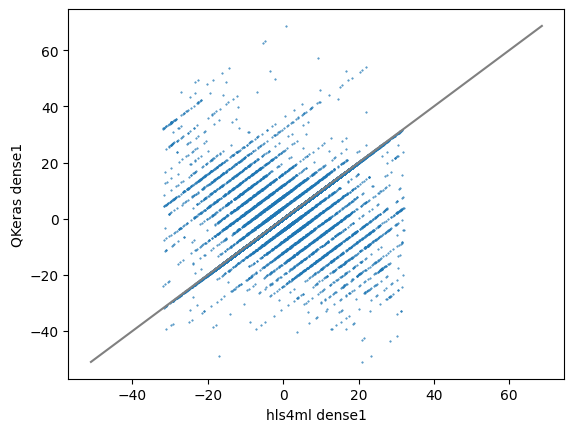

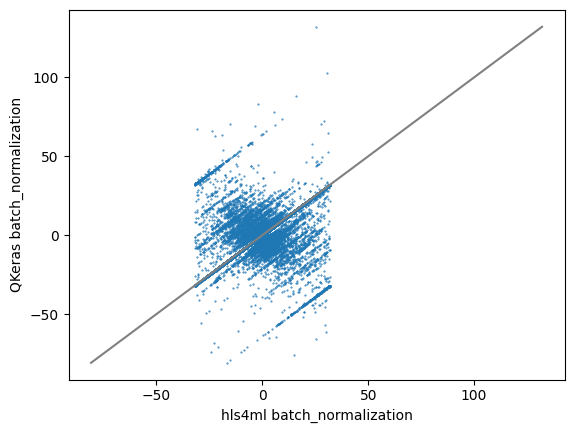

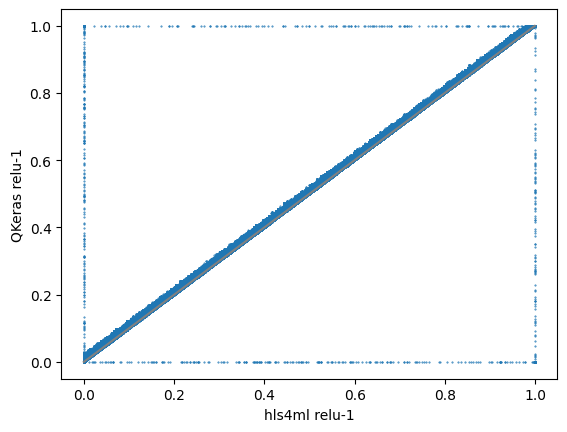

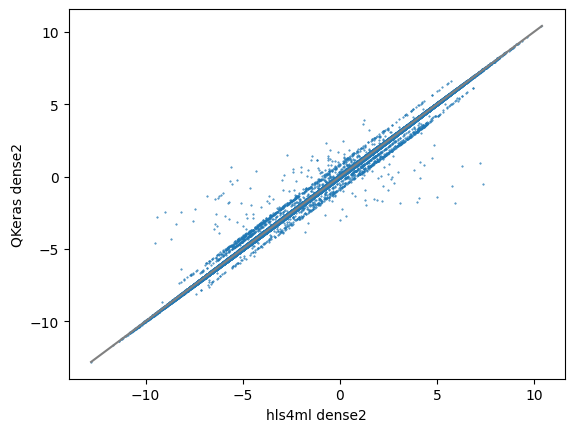

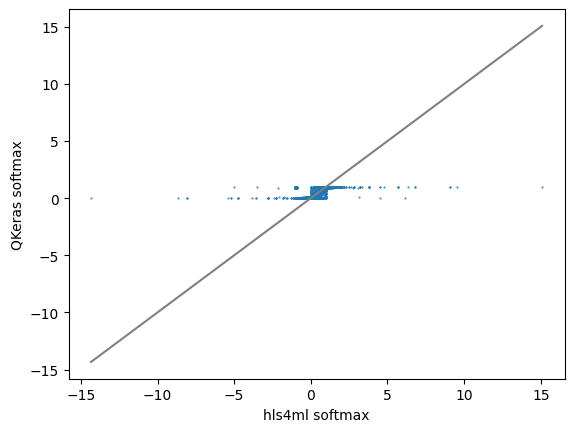

In [38]:
for layer in htrace.keys():
    plt.figure()
    klayer = layer
    if '_alpha' in layer:
        klayer = layer.replace('_alpha', '')
    plt.scatter(htrace[layer].flatten(), trace[klayer].flatten(), s=0.2)
    min_x = min(np.amin(htrace[layer]), np.amin(trace[klayer]))
    max_x = max(np.amax(htrace[layer]), np.amax(trace[klayer]))
    plt.plot([min_x, max_x], [min_x, max_x], c='gray')
    plt.xlabel('hls4ml {}'.format(layer))
    plt.ylabel('QKeras {}'.format(klayer))
    plt.savefig(os.path.join('hls4ml_prj', 'profiling_{}.png'.format(layer)), dpi=300)

In [39]:
for layer in hconfig['LayerName'].keys():
    hconfig['LayerName'][layer]['Trace'] = False

hmodel = hls4ml.converters.convert_from_keras_model(model,
                                                    hls_config=hconfig,
                                                    output_dir='hls4ml_prj',
                                                    part='XC7A100T')

hmodel.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 14]], output shape: [None, 14]
Layer name: dense1, layer type: QDense, input shapes: [[None, 14]], output shape: [None, 128]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: relu-1, layer type: Activation, input shapes: [[None, 128]], output shape: [None, 128]
Layer name: dense2, layer type: QDense, input shapes: [[None, 128]], output shape: [None, 3]
Layer name: softmax, layer type: Softmax, input shapes: [[None, 3]], output shape: [None, 3]
Creating HLS model
Writing HLS project
Done


In [40]:
hpreds = hmodel.predict(np.ascontiguousarray(X_test)) 

In [41]:
from sklearn.metrics import accuracy_score
print('-----------------------------------')
print("QKeras accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(preds, axis=1))))
print("hls4ml accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(hpreds, axis=1))))
print('-----------------------------------')


-----------------------------------
QKeras accuracy: 0.5512270681547559
hls4ml accuracy: 0.5568931764515934
-----------------------------------


In [42]:
%%time
results = hmodel.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.1 (64-bit)
  **** SW Build 2552052 on Fri May 24 14:47:09 MDT 2019
  **** IP Build 2548770 on Fri May 24 18:01:18 MDT 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /tools/Xilinx/Vivado/2019.1/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/tools/Xilinx/Vivado/2019.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'giuseppe' on host 'thorin' (Linux_x86_64 version 5.14.0-1048-oem) on Thu Oct 20 19:16:35 PDT 2022
INFO: [HLS 200-10] On os Ubuntu 22.04.1 LTS
INFO: [HLS 200-10] In directory '/home/giuseppe/research/projects/fnal/CMS_PIX_28/directional-pixel-detectors/multiclassifier/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/giuseppe/research/projects/fnal/CMS_PIX_28/directional-pixel-detectors/multiclassifier/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::softmax_latency<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, softmax_config8>' (firmware/nnet_utils/nnet_activation.h:224:45).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::linear<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, linear_config7>' (firmware/nnet_utils/nnet_activation.h:51:39).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::dense_latency<ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>' (firmware/nnet_utils/nnet_dense_latency.h:39:55).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>' (firmware/nnet_utils/nnet_activation.h:71:39).
INFO: [XFORM 203

INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::mantissa' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:15) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::expv' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:18) automatically.
INFO: [XFORM 203-602] Inlining function 'fp_struct<double>::__signbit' into 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/FloatingPoint/hls_case_IEEE754.h:59) automatically.
INFO: [XFORM 203-602] Inlining function 'generic_cast_IEEE754<int, (ap_q_mode)6, double>' into 'generic_cast_IEEE754<int, double>' (/wrk/2019.1/continuous/2019_05_24_2552052/src/products/hls/hls_lib/hlsmath/include/Float

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:70) by setting 'scale[23].V' to 's4.V.23'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:70) by setting 'scale[24].V

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:70) by setting 'scale[59].V' to 's4.V.59'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_f

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:70) by setting 'scale[93].V' to 's4.V.93'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' at call site (firmware/myproject.cpp:70) by setting 'bias[2].V' to 'b4.V.2'.
INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixe

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:63:9) to 'nnet::normalize<ap_fixed<16, 6, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config4>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0' by setting 'biases[0].V' to 'b2.V.0'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0' by setting 'biases[1].V' to 'b2.V.1'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::de

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[20].V' to 'b2.V.20'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[21].V' to 'b2.V.21'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latenc

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[39].V' to 'b2.V.39'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[58].V' to 'b2.V.58'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[73].V' to 'b2.V.73'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[88].V' to 'b2.V.88'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[103].V' to 'b2.V.103'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0'(firmware/nnet_utils/nnet_mult.h:45:9) to 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0' by setting 'biases[118].V' to 'b2.V.118'.
INFO: [XFORM 203-622] Instantiating function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:69:18) to (firmware/nnet_utils/nnet_activation.h:84:1) in function 'nnet::relu<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, relu_config5>'... converting 257 basic blocks.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_ufixed<10, 0, (ap_q_mode)0, (ap_o_mode)0, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config6>.0.0.0.0' (firmware/nnet_utils/nnet_mult.h:45:9)...357 expression(s) balanced.
INFO: [XFORM 203-11] Balancing expressions in function 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0.0

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_ap_ufixed_10_0_0_0_0_relu_config5_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed,ap_ufixed<10,0,0,0,0>,relu_config5>'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 1.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.62 seconds; current allocated memory: 495.022 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.65 seconds; current allocated memory: 500.178 MB.
INFO: [HLS 200-10] ---------------

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/input_1_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer8_out_0_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer8_out_1_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/layer8_out_2_V' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/const_size_in_1' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject/const_size_out_1' to 'ap_vld'.
INFO: [RTGEN 206-500] Setting interface mode on function 'myproject' to 'ap_ctrl_hs'.
INFO: [RTGEN 206-104] Estimated max fanout for 'myproject' is 5424 from HDL expression: (1'b0 == ap_block_pp0_stage0_11001)
INFO:

In [43]:
print('-----------------------------------')
#print(results) # Print hashmap
hls_results=results
#['CSynthesisReport'] 
print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
print("BRAM_18K:               {}, {:0.1f}% (Aval. {})".format(hls_results['BRAM_18K'], int(hls_results['BRAM_18K'])*100.0/int(hls_results['AvailableBRAM_18K']), hls_results['AvailableBRAM_18K']))
print("DSP48E:                 {}, {:0.1f}% (Aval. {})".format(hls_results['DSP48E'], int(hls_results['DSP48E'])*100.0/int(hls_results['AvailableDSP48E']), hls_results['AvailableDSP48E']))
print("FF:                     {}, {:0.1f}% (Aval. {})".format(hls_results['FF'], int(hls_results['FF'])*100.0/int(hls_results['AvailableFF']), hls_results['AvailableFF']))
print("LUT:                    {}, {:0.1f}% (Aval. {})".format(hls_results['LUT'], int(hls_results['LUT'])*100.0/int(hls_results['AvailableLUT']), hls_results['AvailableLUT']))
#print("URAM:                   {}, {} (Aval. {})".format(hls_results['URAM'], int(hls_results['URAM'])*100.0/int(hls_results['AvailableURAM']), hls_results['AvailableURAM']))
print('-----------------------------------')

-----------------------------------
Estimated Clock Period: 4.060 ns
Best/Worst Latency:     24 / 24
Interval Min/Max:       1 / 1
BRAM_18K:               3, 1.1% (Aval. 270)
DSP48E:                 148, 61.7% (Aval. 240)
FF:                     38218, 30.1% (Aval. 126800)
LUT:                    60899, 96.1% (Aval. 63400)
-----------------------------------
